# Using Topic Modelling to Analyse 10-K Filings - Auquan

**by Wian Stipp**

## 1. Getting The Data

### 1.1. Install Relevant Packages

In [0]:
#prevents printing the install messages
%%capture
!pip install sec-edgar-downloader
!pip install html2text

In [0]:
from sec_edgar_downloader import Downloader
import textwrap
import html2text
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.notebook import tqdm

### 1.2. Download The Data

We use a tool called SEC Edgar Downloader to scrape the html from the 10-k reports. For more details: https://pypi.org/project/sec-edgar-downloader/.

We will download the data directly into the default working directory that Google Colab uses. We also need to specify which companies we would like data for.

In [0]:
PATH = "/content"
dl = Downloader(PATH)

In [0]:
SYMBOLS = ["GOOGL", "MSFT", "AMZN",  "IBM", "NVDA"]
           # The ARGS variable holds some hardcoded information that we might need to reuse
ARGS = {"Type of Report": "10-K",
        "Companies": SYMBOLS,
        }

Then we can simply download the data by looping through each of the companies and downloading using the SEC Edgar tool. The data will download into the "content" directory as we specified above.

Throughout this notebook we also use the tqdm_notebook tool from tqdm. This is essentially an awesome progress bar that helps you see how far you are through a loop and the expected remaining time. https://github.com/tqdm/tqdm

In [0]:
for symbol in tqdm_notebook(SYMBOLS):
  dl.get(ARGS["Type of Report"], symbol)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### 1.3. Extract Relevant Text

Now that we have downloaded the data, we need to extract the relevant text from the files. We also need to extract the year of the 10-k filing. This is easy since it is included in the document name.

To extract the text we just use a rough approximation to take a portion of text near the start of the report.

Html2text is another tool used here to convert from HTML, which all the files are in, to text.

In [0]:
def createDataframe(company_list):

  df = pd.DataFrame(columns=["Company", "Year", "Report"])
  start_index = {"AMZN": 49257}
  end_index = {"AMZN": 185190}

  for company in tqdm(company_list):
    try:
      reports = os.listdir(PATH + "/sec_edgar_filings/" + company + "/10-K")
      for index, report in enumerate(reports):
        opened_file = open(PATH + "/sec_edgar_filings/" + company + "/10-K/" + report, "r")
        full_text = opened_file.read()
        full_text_length = len(full_text)
        opened_file.close()
        try:
          if company in start_index.keys():
            start = start_index[company]
            end = end_index[company]
          else:
            start = 44800
            end = 200000
          text = html2text.html2text(full_text[start:end])
          t_len = len(text)
          relevant_text = text[round(t_len*0.003):round(t_len*0.08)]
          yr = int(report.split("-")[1])
          if yr > 20:
            yr = 1900 + yr
          else:
            yr = 2000 + yr
          df = df.append({"Company": company, "Year": yr, "Report": relevant_text}, ignore_index=True)
        except:
          print(company, report, "Failed")
    except: pass
  return df


In [0]:
dataframe = createDataframe(ARGS["Companies"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


### 1.4. Data Cleaning

In [0]:
import re

def clean_dataset(text):
    # Make Lowercase
    text = text.lower()
    # Remove some remaining html
    text = re.sub(r"font", "", text)
    text = re.sub(r"size", "", text)
    text = re.sub(r"pt", "", text)
    text = re.sub(r"px", "", text)
    text = re.sub(r"padding", "", text)
    text = re.sub(r"family", "", text)
    text = re.sub(r"style", "", text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r"\&\w*;", "", text)
    # Remove tickers
    text = re.sub(r"\$\w*", "", text)
    # Remove hyperlinks & URLs
    text = re.sub(r"https?:\/\/.*\/\w*", "", text)
    text = re.sub(r"http(\S)+", "", text)
    text = re.sub(r"http ...", "", text)
    # Remove whitespace (including new line characters)
    text = re.sub(r"\s\s+", "", text)
    text = re.sub(r"[ ]{2, }", " ", text)
    # &, < and >
    text = re.sub(r"&amp;?", "and", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&gt;", ">", text)
    # Insert space between words and punctuation marks
    text = re.sub(r'\[\[(?:[^\]|]*\|)?([^\]|]*)\]\]', r'\1', text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text = "".join(c for c in text if c <= "\uFFFF")
    text = text.strip()
    text = " ".join(text.split())

    return text

In [0]:
dataframe["Report"] = dataframe["Report"].apply(clean_dataset)

## 2. Data Exploration

### 2.1. Word Cloud

Word clouds, as basic as they are, can be useful to visually represent the main themes in the report.

In [0]:
from wordcloud import WordCloud

In [0]:
def make_wordcloud(series):
  all_text = ','.join(list(series.values))
  wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3)
  wordcloud.generate(all_text)
  return wordcloud.to_image()

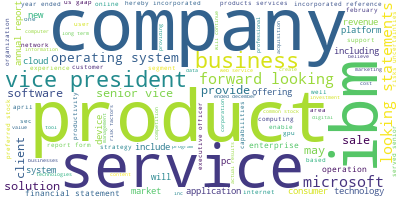

In [0]:
make_wordcloud(dataframe.Report)

### 2.2. Word Cloud by Company

Let's see if we can see any immediate differences between companies by just using the word cloud. Since we wrote the word cloud generation into a function called <code>make_wordcloud</code> we can easily reuse it! Let's look at Alphabet vs Microsoft.

In [0]:
import numpy as np

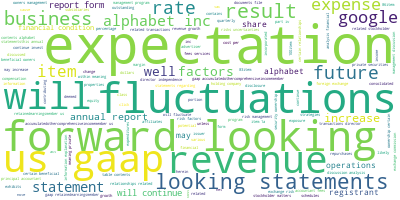

In [0]:
GOOGL_condition = (dataframe.Company == "GOOGL")
make_wordcloud(dataframe[GOOGL_condition].Report)

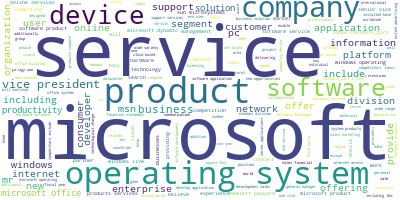

In [0]:
MSFT_condition = (dataframe.Company == "MSFT")
make_wordcloud(dataframe[MSFT_condition].Report)

Just by visualising the data from Alphabet vs Microsoft, we can see that Microsoft seems to talk more about their services and products, while Alphabet seems to be more concerned about macroeconomic factors.

## 3. Topic Modelling

We will be using LDA for the Topic Model. LDA stands for Latent Dirichlet Allocation. If we break down that term a little, we notice the word "latent", which means unobserved; Dirichlet is named after the German mathematician and "allocation" because of the nature of the problem of allocating latent topics to chunks of text.

LDA is actually an unsupervised technique, meaning we do not need labelled data, which is a big benefit when you have many 10-k filings as we do. The mathematics behind it is very deep, because it uses Bayesian methods, and so we won't cover it here. If you would like to get a better idea of the mathematics, then I recommend you start here: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation or view the original paper (with Andrew Ng) here: https://web.archive.org/web/20120501152722/http://jmlr.csail.mit.edu/papers/v3/blei03a.html

An intuitive way to understand how topic modelling works is that the model imagines each document contains a fixed number of topics. For each topic, there are certain words that are associated with that topic. Then a document can be modeled as some topics that are generating some words associated with the topics. For example, a document discussing Covid-19 and unemployment impact can be modelled as containing the topics: “Covid-19”, “economics”, “health” and “unemployment”. Each one of these topics has a specific vocabulary associated with it, which appears in the document. The model knows the document isn’t discussing the topic “trade” because words associated with “trade” do not appear in the document.


### 3.1. Text Preprocessing

NTLK, Gensim and SpaCy are the primary packages we will be using to clean the text, preprocess it and then build the model. There libraries are very common in the NLP space nowadays and should become familar to you overtime.

We also use a special plotting tool called pyLDAvis. As the name suggests this enables you to visualise the Topic Modelling output by using a number of techniques, such as dimensionality reduction.

To prepare the text for the model we need to do a few things. The first is to remove stopwords, which are words that are not going to add much meaning to the text and hence just add noise into the model. The NTLK package has a lot of these words listed which we can make use of right away. Have a look at some of them below, stored in the list variable <code>stop_words</code>.

Note: If you find any other words that could be considered meaningless which remain after filtering out the stopwords, then you can just append them to the list.

In [0]:
%%capture
import nltk; nltk.download('stopwords')
!python3 -m spacy download en

In [0]:
  %%capture
from pprint import pprint

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Gensim is a great package that supports topic modelling and other NLP tools
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
  """
  This function simply removes all of the stopwords we have specified in the list stop_words.
  """
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=3):
  """
  https://radimrehurek.com/gensim/models/phrases.html
  """
  bigram = gensim.models.Phrases(words, min_count = bi_min)
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  return bigram_mod

def get_corpus(df):  
    words = list(sent_to_words(df.Report))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[report] for report in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=3, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [0]:
train_corpus, train_id2word, bigram_train = get_corpus(dataframe)

We need to choose the number of topics we are looking for. This is a hyperparameter and cannot be directly optimised.

In [0]:
NUM_TOPICS = 10

### 3.2. Model

In [0]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=NUM_TOPICS,
                           id2word=train_id2word,
                           chunksize=50,
                           workers=4,
                           passes=100,
                           eval_every = 1,
                           per_word_topics=True)

In [0]:
coherencemodel = CoherenceModel(lda_train, texts=bigram_train, dictionary=train_id2word)
print (coherencemodel.get_coherence())

0.527596795083962


In [0]:
# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_train, train_corpus, train_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.103642  0.131326       1        1  19.124634
8      0.129613  0.107826       2        1  17.262774
9      0.185937  0.152179       3        1  11.212565
4     -0.136560  0.042468       4        1   9.500261
7     -0.036778 -0.133103       5        1   9.168936
2     -0.061950  0.125307       6        1   8.482840
3      0.114708 -0.205673       7        1   8.055409
5     -0.264601 -0.000197       8        1   7.146316
0      0.156273 -0.189183       9        1   5.796934
6     -0.190284 -0.030949      10        1   4.249334, topic_info=                Term        Freq       Total Category  logprob  loglift
955               mr  101.000000  101.000000  Default  30.0000  30.0000
1027  vice_president  109.000000  109.000000  Default  29.0000  29.0000
182              sec   94.000000   94.000000  Default  28.0000  28.0000
555        microsoft  252.000000  252.000000  Default  27.0000  27.0000
979        president  113.000000  113.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
2271            full    5.916402   15.215563  Topic10  -5.4847   2.2138
2269        entitled    5.916403   16.676447  Topic10  -5.4847   2.1221
582              one    6.942564   53.356182  Topic10  -5.3248   1.1191
82         following    6.694802   50.540009  Topic10  -5.3611   1.1370
1505        graphics    6.522927   61.322559  Topic10  -5.3871   0.9176

[677 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2156      4  0.953224      acceable
1265      3  0.878192   accessories
2688      4  0.908284  accompanying
356       1  0.023555        across
356       2  0.683085        across
...     ...       ...           ...
1035      6  0.055909          year
1035      8  0.223635          year
1035     10  0.027954          year
2391      4  0.084318    year_ended
2391     10  0.843184    year_ended

[1363 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 10, 5, 8, 3, 4, 6, 1, 7])

## 4. Improving The Model

As the results show, the model is decent at finding topics, but we can do better. We will look at two ways to improve the model: finding the optimal number of topics, and using Mallet. 

### 4.1. Mallet

Mallet (Machine Learning for Language Toolkit), is a topic modelling package written in Java. Gensim has a wrapper to interact with the package, which we will take advantage of.

The difference between the LDA model we have been using and Mallet is that the original LDA using variational Bayes sampling, while Mallet uses collapsed Gibbs sampling. The latter is more precise, but is slower. In most cases Mallet performs much better than original LDA, so we will test it on our data. Also, as we will see, Mallet will dramatically increase our coherence score, demonstrating that it is better suited for this task as compared with the original LDA model.

We need to go through some additional steps to properly install Mallet and the wrapper from Gensim. Here is an excellent guide to using Mallet with Google Colab: https://github.com/polsci/colab-gensim-mallet

In [0]:
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [0]:
%%capture
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [0]:
from gensim.models.wrappers import LdaMallet

In [0]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_mallet = LdaMallet(
        mallet_path,
        corpus=train_corpus,
        num_topics=NUM_TOPICS,
        id2word=train_id2word,
    )

In [0]:
gensimmodelMallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

In [0]:
coherencemodel = CoherenceModel(gensimmodelMallet, texts=bigram_train, dictionary=train_id2word)
print(coherencemodel.get_coherence())

0.7143588181690383


As you can see we get a huge boost in coherence!

In [0]:
# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(gensimmodelMallet, train_corpus, train_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.000360  0.000224       1        1  13.321327
3     -0.000468  0.000296       2        1  12.933582
5      0.000725  0.000287       3        1  12.756409
0      0.000552 -0.000247       4        1  11.026037
2      0.000429  0.000552       5        1   9.672990
9     -0.000851  0.000098       6        1   9.245948
4     -0.000091 -0.001284       7        1   9.202207
7     -0.000468  0.000115       8        1   8.422534
8      0.000418 -0.000210       9        1   7.993819
1      0.000114  0.000169      10        1   5.425145, topic_info=                     Term       Freq      Total Category  logprob  loglift
233     owners_management  11.000000  11.000000  Default  30.0000  30.0000
1427              enables  11.000000  11.000000  Default  29.0000  29.0000
1474                tasks  12.000000  12.000000  Default  28.0000  28.0000
186   similar_expressions  11.000000  11.000000  Default  27.0000  27.0000
1434                forms  11.000000  11.000000  Default  26.0000  26.0000
...                   ...        ...        ...      ...      ...      ...
1252                suite   0.794960  12.209497  Topic10  -7.7362   0.1824
2174          governments   0.771161  11.730112  Topic10  -7.7666   0.1921
2104          smithsonian   0.772784  11.885209  Topic10  -7.7645   0.1811
186   similar_expressions   0.770173  11.686620  Topic10  -7.7679   0.1945
2030          represented   0.770439  11.962074  Topic10  -7.7675   0.1716

[456 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
716       1  0.165279                access
716       2  0.165279                access
716       3  0.082639                access
716       4  0.082639                access
716       5  0.082639                access
...     ...       ...                   ...
2112      6  0.083963  worldwide_operations
2112      7  0.083963  worldwide_operations
2112      8  0.083963  worldwide_operations
2112      9  0.083963  worldwide_operations
2112     10  0.083963  worldwide_operations

[4165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 6, 1, 3, 10, 5, 8, 9, 2])

### 4.2. Finding Optimal Number of Topics

There is no easy way to obtain the optimal number of topics you should use. This is a hyperparameter and must be tuned manually. One way, albeit still not great, is to create a number of models, each with different topic numbers, and calculate the coherence scores for each model. Then we plot the coherence vs. number of topics, and find the elbow - the point at which the curve tapers off.

In [0]:
def plot_coherence(dictionary, corpus, texts, maximum=30, minimum=3, step=4):

  coherence_values = []
  model_list = []

  for num_topics in tqdm(range(minimum, maximum, step)):
    model = LdaMallet(
        mallet_path,
        corpus=train_corpus,
        num_topics=num_topics,
        id2word=train_id2word,
    )
    gensimMallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
    model_list.append(gensimMallet)
    coherencemodel = CoherenceModel(model=gensimMallet, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

  return model_list, coherence_values

In [0]:
models, coherences = plot_coherence(train_id2word, train_corpus, bigram_train)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


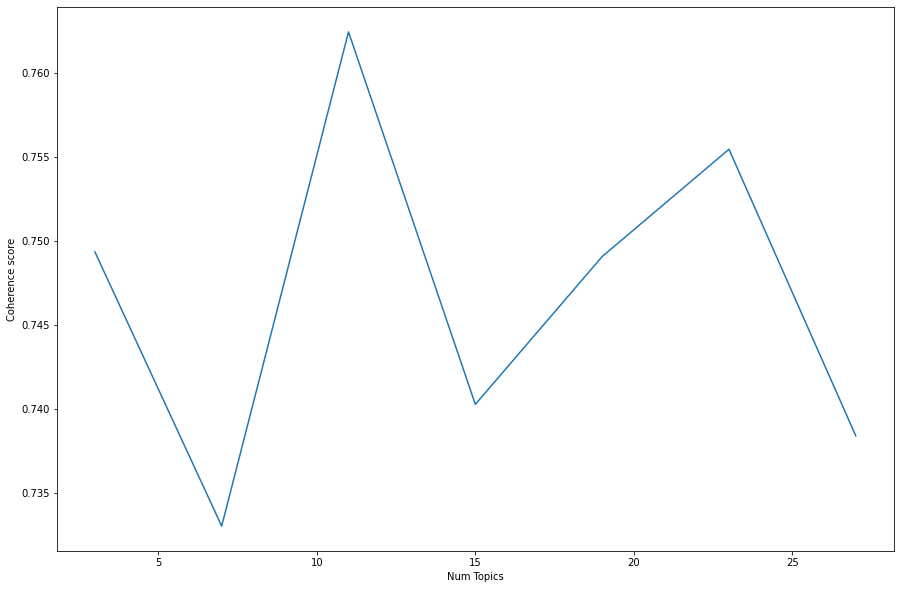

In [0]:
x = range(3, 30, 4)
plt.figure(figsize=(15, 10))
plt.plot(x, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

Unfortunately it looks like this is quite messy, but the scale on the y-axis is quite narrow, so it doesn't make too much difference which value we choose. Also, if you run this again, the line can look much different. Therefore, we should choose a number of topics that makes sense in this content. The fewer topics we choose, the more general and broad the topics would be and vice versa.

## 5. Using The Model

Using the knowledge from the optimal topics we can select a "best model" to analyse the data with.

### 5.1. Visualisation

In [0]:
bestModelMallet = models[1]

In [0]:
# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(bestModelMallet, train_corpus, train_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.000126  0.000056       1        1  16.683084
3     -0.000627 -0.000222       2        1  16.008021
4     -0.000090 -0.000975       3        1  15.432293
2      0.000450  0.000229       4        1  13.996191
5      0.000169 -0.000304       5        1  13.995345
1      0.000820  0.000447       6        1  12.665465
6     -0.000848  0.000769       7        1  11.219600, topic_info=                     Term      Freq      Total Category  logprob  loglift
2924            appraised  9.000000   9.000000  Default  30.0000  30.0000
3259  graphics_processors  8.000000   8.000000  Default  29.0000  29.0000
253                  exce  9.000000   9.000000  Default  28.0000  28.0000
2254    number_trademarks  8.000000   8.000000  Default  27.0000  27.0000
2509              execute  9.000000   9.000000  Default  26.0000  26.0000
...                   ...       ...        ...      ...      ...      ...
1623        joint_venture  1.246374   9.433985   Topic7  -7.9295   0.1634
36               continue  1.257906   9.751053   Topic7  -7.9203   0.1396
1163             possible  1.270242  10.262561   Topic7  -7.9105   0.0982
576                oracle  1.246827   9.544186   Topic7  -7.9291   0.1522
2087             wide_web  1.242973   9.660450   Topic7  -7.9322   0.1370

[340 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1927      1  0.109326  access_unlimited
1927      2  0.218651  access_unlimited
1927      3  0.109326  access_unlimited
1927      4  0.109326  access_unlimited
1927      5  0.109326  access_unlimited
...     ...       ...               ...
1587      3  0.103334         xbox_xbox
1587      4  0.103334         xbox_xbox
1587      5  0.206668         xbox_xbox
1587      6  0.103334         xbox_xbox
1587      7  0.103334         xbox_xbox

[2184 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 6, 2, 7])

### 5.2. Trends

One great thing we can now do is look at how certain mentions of certain topics change overtime within each company. Inspecting topic 3 reveals the terms: “improved_advertising”, “cloud_platforms”, “phones_intelligent”, “information_investors”, “global_compute” and so on. This topic can be interpreted as integrating technology with current business practices. Let’s simply call with topic “Tech” for short.

In [0]:
def get_df_topics(row, topic_id):
  words = list(sent_to_words([row]))
  words = remove_stopwords(words)
  bigram = bigrams(words)
  bigram = [bigram[report] for report in words]
  tokens = train_id2word.doc2bow(bigram[0])
  topics = bestModelMallet.get_document_topics(tokens)
  if topics is not None:
    for index, score in topics:
      if index == topic_id:
        return score

In [0]:
MSFT_df = dataframe[dataframe.Company == "MSFT"]
MSFT_df = MSFT_df.sort_values("Year")
MSFT_df.head()

,Company,Year,Report
30,MSFT,1994,anufacturing and distribution operation consis...
8,MSFT,1995,mpete with unix-based operating systems from a...
13,MSFT,1996,operating systems from a wide range of compani...
18,MSFT,1997,distribute microsoft's copyrighted software pr...
24,MSFT,1998,providing these technical services. notes to f...


In [0]:
score_list = []
year_list = []
for index, row in MSFT_df.iterrows():
  score_list.append(get_df_topics(row.Report, 3))
  year_list.append(row.Year)

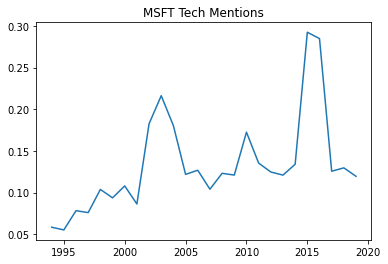

In [0]:
plt.plot(year_list, score_list)
plt.title("MSFT Tech Mentions")
plt.show()

As we can see, mentions of topic 3, which seems to represent technology has been fluctuating since 1995, and more recently is at a low-point for Microsoft. Let's compare with IBM.

In [0]:
IBM_df = dataframe[dataframe.Company == "IBM"]
IBM_df = IBM_df.sort_values("Year")
IBM_df.head()

,Company,Year,Report
59,IBM,1994,tatement no. 33-6889 on form s-3 filed on july...
61,IBM,1995,erland)................. switzerland 100 ibm u...
68,IBM,1996,world trade corporation..........................
78,IBM,1997,with any and all amendments and subsequent res...
71,IBM,1998,the ibm supplemental executive retirement plan...


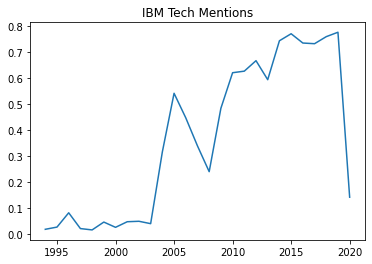

In [0]:
score_list = []
year_list = []
for index, row in IBM_df.iterrows():
  score_list.append(get_df_topics(row.Report, 3))
  year_list.append(row.Year)

plt.plot(year_list, score_list)
plt.title("IBM Tech Mentions")
plt.show()

Interesting! IBM seems to have been on an uptrend since 1995, but in the last two years has dramatically fallen to 2004 levels. Now what about Amazon?

In [0]:
AMZN_df = dataframe[dataframe.Company == "AMZN"]
AMZN_df = AMZN_df.sort_values("Year")
AMZN_df.head()

,Company,Year,Report
51,AMZN,1998,"prospects, financial condition and results of ..."
43,AMZN,1999,ecutive officers and directors of the company ...
50,AMZN,2000,losses from a major interruion. computer virus...
44,AMZN,2001,iminish the value of our trademarks and other ...
47,AMZN,2002,ional retail seasonality. traditional retail s...


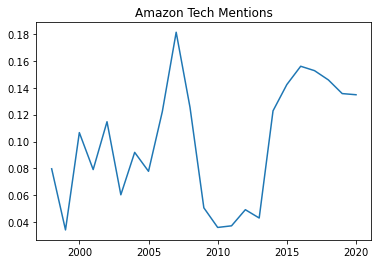

In [0]:
score_list = []
year_list = []
for index, row in AMZN_df.iterrows():
  score_list.append(get_df_topics(row.Report, 3))
  year_list.append(row.Year)

plt.plot(year_list, score_list)
plt.title("Amazon Tech Mentions")
plt.show()

## 6. Conclusion


We have learned about topic modelling, and more specifically LDA and Mallet. Topic modelling is a great unsupervised tool for extracting topics from documents, and Mallet is a particular model for performing topic modelling, which improves on the weaknesses of the original LDA model - precision.

We learned how to preprocess and clean text for building an LDA/Mallet model. First, cleaning the data with regular expressions, then removing stopwords, and creating a Bag of Words model. We discussed the assumptions of the BoW model, but recognised that it can be a useful simplification in many cases.

Then we built the Mallet and LDA models, chose the optimal number of topics, and visualised the topics in pyLDAvis. The visualisation methods of pyLDAvis were covered in detail.

After finding the topic representation for each document, we saw how further work can be done, such as looking at how certain topics trend overtime.

If you would like to go further, I would recommend looking into Deep LDA or Neural Topic Modelling with Reinforcement Learning. 
